# Kaggle: Titanic: Machine Learning from Disaster

### Supported by Dataquest

In this notebook I will implement the techniques learned to make a good submission to a Kaggle competition and apply it mostly on my own. This is part of a guided project created by Dataquest. I started to do this Kaggle competition on my own and happened to stumble upon this course in Dataquest that helps walk you through the process of a Kaggle submission.

In [15]:
#first to import the modules and the data
import pandas as pd
import numpy as np

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")
holdout.head()


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [2]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [16]:
def run_functions(df): #applies functions to dataframe
    process_missing(df)
    process_age(df)
    process_fare(df)
    process_titles(df)
    process_cabin(df)
    
    df = create_dummies(df, "Age_categories")
    df = create_dummies(df, "Fare_categories")
    df = create_dummies(df, "Title")
    df = create_dummies(df, "Cabin_type")
    df = create_dummies(df, "Sex")
    return df
    
train = run_functions(train)
holdout = run_functions(holdout)

## Data Exploration
Now to do some data exploration and feature engineering. I will tinker with Sibsp and Parch columns.

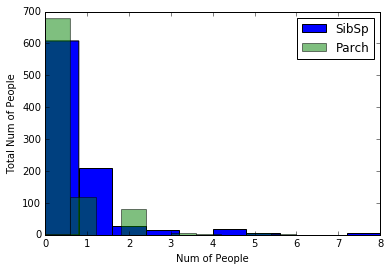

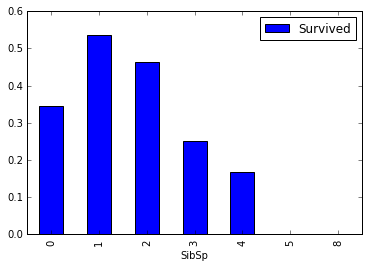

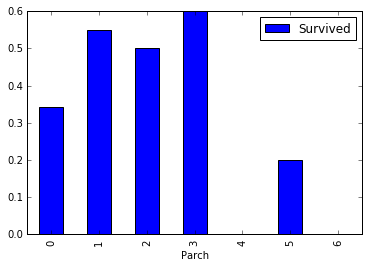

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

explore = train.copy() #need to make copy so that original stays unaltered
plt.figure()
plt.hist(explore['SibSp'], label='Sibsp') #blue
plt.hist(explore['Parch'], alpha=0.5, label='Parch') #green
plt.xlabel("Num of People")
plt.ylabel("Total Num of People")
plt.legend(["SibSp", "Parch"])

sibsp_pivot = explore.pivot_table(index='SibSp', values='Survived')
sibsp_pivot.plot.bar()

parch_pivot = explore.pivot_table(index='Parch', values="Survived")
parch_pivot.plot.bar()


From what I could plot it seems as though the majority of people had 0-1 sibling/spouse or parent/child set. 

Based on the SibSp, the survival rate was highest if you only had one. 2 was the second highest.

Based on the Parch, the survival rate was highest if you were in an intermediate family of 3. 1 was the second highest. 

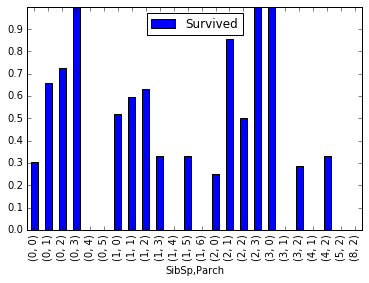

In [5]:
# a better way to visualize both columns based on survival
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
cols = ["SibSp", "Parch"]

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index=cols,values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

#shows that only 30% of passengers who had no family members onboard survived

From the above information, we can create a new feature that distinguishes between a lone passenger and a passenger with family:

In [17]:
def has_fam(df):
    df["familysize"] = df[["SibSp", "Parch"]].sum(axis=1)
    df["isalone"] = 0
    df.loc[(df["familysize"] == 0),"isalone"] = 1
    df = df.drop("familysize",axis=1)
    return df

train = has_fam(train)
holdout = has_fam(holdout)

## Feature Selection
Now to incorporate RFECV (Random Feature Election Cross Validation) to find the best features that is most representative of the data

In [20]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # Remove non-numeric columns, columns that have null values
    df = df.select_dtypes([np.number]).dropna(axis=1)
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]
    
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf,cv=10)
    selector.fit(all_X,all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))
    
    return best_columns

best_features_train = select_features(train)

Best Columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    all_X = df[features]
    all_y = df["Survived"]
    
    models= [ {'name': "LogisticRegression", 
               'estimator': LogisticRegression(),
              'hyperparameters': {"solver": ["newton-cg", "lbfgs", "liblinear"]} },

              {'name': "KNeighborsClassifier", 
               "estimator": KNeighborsClassifier(),
              'hyperparameters': {"n_neighbors": range(1,20,2), "weights": ["distance", "uniform"], 
               "algorithm": ["ball_tree", "kd_tree", "brute"], "p": [1,2]}  },
    
              {'name': 'RandomForestClassifier', 
               'estimator': RandomForestClassifier(random_state=1),
              'hyperparameters': {"n_estimators": [4, 6, 9], "criterion": ["entropy", "gini"], "max_depth": [2, 5, 10],
              "max_features": ["log2", "sqrt"], "min_samples_leaf": [1, 5, 8], "min_samples_split": [2, 3, 5]}   }  ]
    

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))
    
    return models

result = select_model(train, best_features_train)


LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'brute', 'p': 1, 'n_neighbors': 5, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8294051627384961
Best Parameters: {'n_estimators': 4, 'max_features': 'log2', 'min_samples_leaf': 1, 'max_depth': 5, 'criterion': 'entropy', 'min_samples_split': 5}



In [24]:
#created function to save and submit multiple trials
def save_submission_file(model,columns,subname):

    holdout_predictions = model.predict(holdout[columns])
    holdout_ids = holdout["PassengerId"]
    submission_df = {"PassengerId": holdout_ids, "Survived": holdout_predictions}
    submission = pd.DataFrame(submission_df)
    submission.to_csv(subname,index=False)
    
    return print("Done!")

best_rf_model = result[2]["best_model"]
save_submission_file(best_rf_model, best_features_train,'dqsubmission.csv')

Done!


Definitely not a bad start! Going to submit this version and add different algorithms and models to experiment with. Also may try to do more feature engineering for practice. The new stuff extending from the Dataquest guided project will follow this text box. Let's do this!